<a href="https://colab.research.google.com/github/lucasarags/BootcampMachineLearnATV2/blob/master/face_detection_yolo_nas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📦 Required Dependencies

In [1]:
!pip install super_gradients

import os
import shutil
import random
from tqdm.notebook import tqdm
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
import torch
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to 

[2023-11-24 22:38:33] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-11-24 22:38:33] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-11-24 22:38:33] INFO - utils.py - NumExpr defaulting to 2 threads.
[2023-11-24 22:38:42] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-11-24 22:38:42] WARNING - export.py - Failed to import pytorch_quantization
[2023-11-24 22:38:42] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-11-24 22:38:42] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-11-24 22:38:42] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-11-24 22:38:42] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-11-24 22:38:42] WARNING - env_sanity_check.py - Failed to verify installed packages: sphinx-rtd-theme required but not found
[2023-11-24 22:38:42] WARNING - env_sanity_check.py - Failed to verify i

# 💾 Datasets and DataLoaders

In [2]:

from google.colab import drive
import zipfile

drive.mount("/content/drive", force_remount=True)

# Path to your zip file
path = '/content/drive/My Drive/face-detection-dataset.zip'

# Extract the zip file
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

# Define your dataset parameters
dataset_params = {
    'data_dir': '/content/face-detection-dataset',
    'train_images_dir': '/content/face-detection-dataset/images/train',
    'train_labels_dir': '/content/face-detection-dataset/labels/train',
    'val_images_dir': '/content/face-detection-dataset/images/val',
    'val_labels_dir': '/content/face-detection-dataset/labels/val',
    'test_images_dir': '/content/face-detection-dataset/images/test',
    'test_labels_dir': '/content/face-detection-dataset/labels/test',
    'classes': ['face']
}


Mounted at /content/drive


In [3]:
import os
print(os.listdir('/content/face-detection-dataset'))

In [4]:
MODEL_ARCH = 'yolo_nas_s'
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 20
MAX_EPOCHS = 20
CHECKPOINT_DIR = f'/kaggle/working/'
EXPERIMENT_NAME = f'yolo_nas_face'


In [5]:
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from super_gradients.training import Trainer
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from torch.utils.data import DataLoader

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 1
    }
)

#test_data = coco_detection_yolo_format_val(
#    dataset_params={
#        'data_dir': dataset_params['data_dir'],
#        'images_dir': dataset_params['test_images_dir'],
#        'labels_dir': dataset_params['test_labels_dir'],
#        'classes': dataset_params['classes']
#    },
#    dataloader_params={
#        'batch_size': BATCH_SIZE,
#        'num_workers': 1
#    }
#)

['labels', 'images']


[2023-11-24 22:39:20] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1000/1000 [00:00<00:00, 1994.35it/s]
[2023-11-24 22:39:21] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


In [6]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

Indexing dataset annotations: 100%|██████████| 500/500 [00:00<00:00, 2815.93it/s]


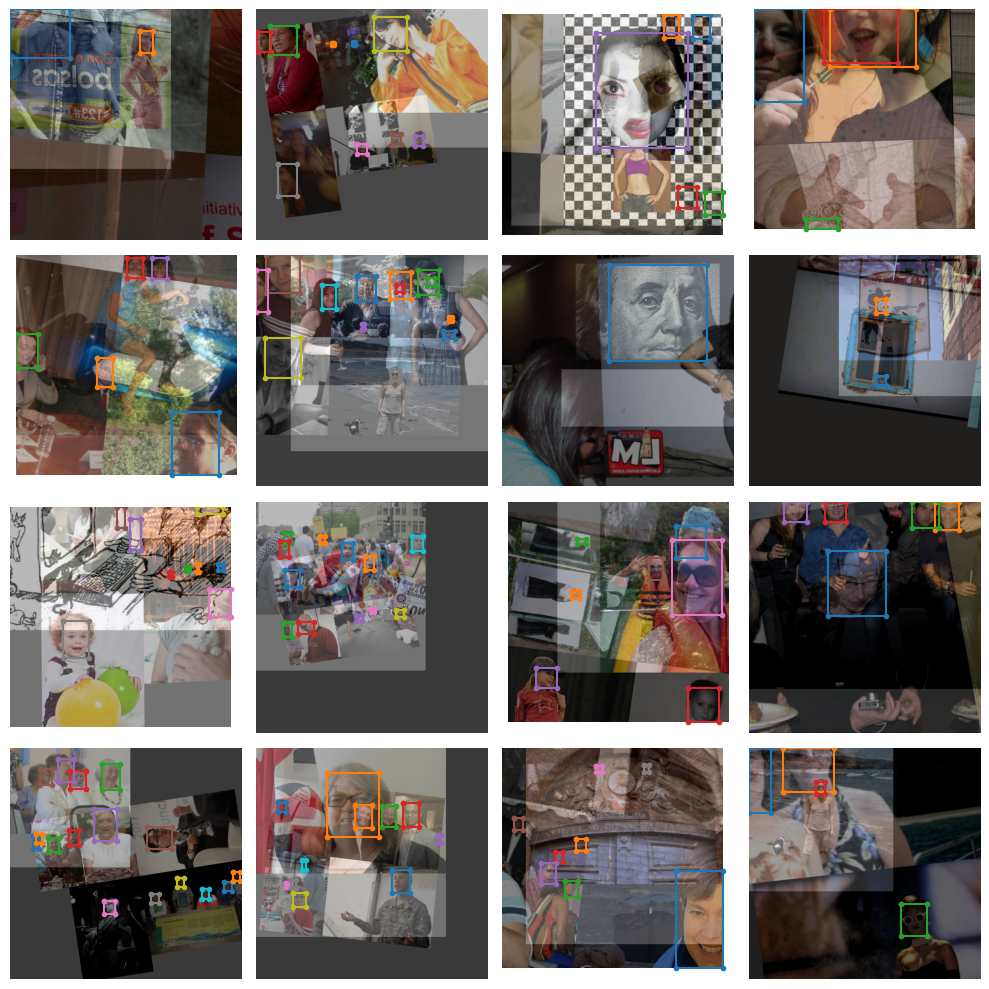

In [7]:
train_data.dataset.plot()

# ⚙️ Initializing the model

In [8]:
model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

[2023-11-24 22:39:29] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 73.1M/73.1M [00:02<00:00, 36.3MB/s]
[2023-11-24 22:39:32] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s


# 🔍 Training parameters

In [9]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

optimizer = optim.Adam(model.parameters(), lr=train_params["initial_lr"], weight_decay=train_params["optimizer_params"]["weight_decay"])

scheduler = CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS, eta_min=train_params["initial_lr"] * train_params["cosine_final_lr_ratio"])

train_params["scheduler"] = scheduler

# ⏳ Training the model

In [10]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

In [11]:
print("Starting training loop...")



trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)



print("Training loop completed.")

[2023-11-24 22:39:32] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20231124_223932_618343`
[2023-11-24 22:39:32] INFO - sg_trainer.py - Checkpoints directory: /kaggle/working/yolo_nas_face/RUN_20231124_223932_618343


Starting training loop...
The console stream is now moved to /kaggle/working/yolo_nas_face/RUN_20231124_223932_618343/console_Nov24_22_39_32.txt


[2023-11-24 22:39:32] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:107: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/super_gradients/training/sg_trainer/sg_trainer.py:1686: UserWarning: M

# 📈 Inference and Visualization

In [1]:
MODEL_ARCH = "yolo_nas_s"
best_model_path = "/kaggle/working/yolo_nas_face/RUN_20231124_213642_828377/average_model.pth"

# Carregue o modelo
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=best_model_path
).to(DEVICE)

NameError: ignored

In [ ]:
img_1 = "/content/face-detection-dataset/images/val/0003d5dfa8f0dd41.jpg"
best_model.predict(img_1).show()

In [ ]:
img_2 = "/content/face-detection-dataset/images/val/03de97cd4c0c2dbc.jpg"
best_model.predict(img_2).show()